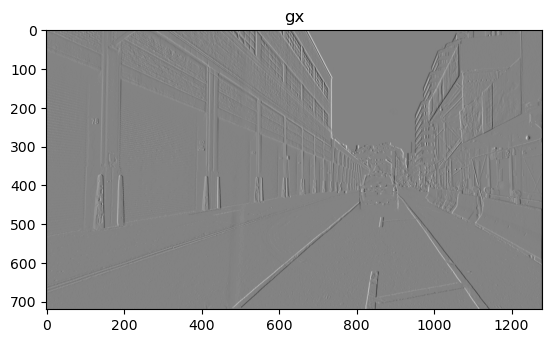

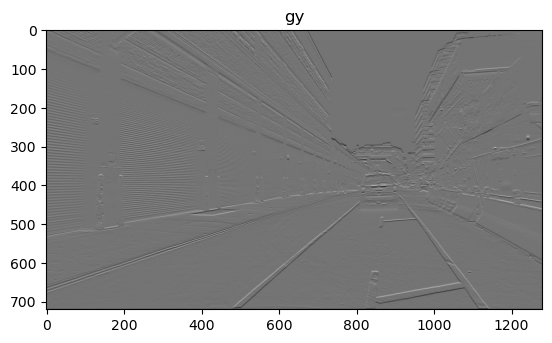

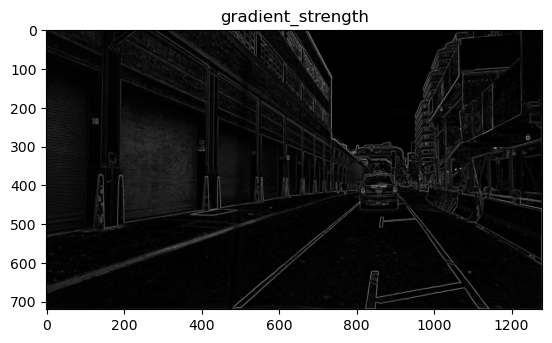

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


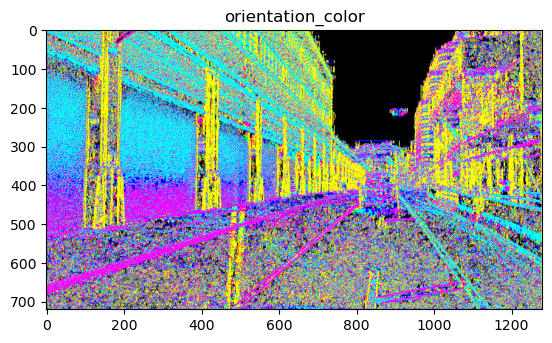

ValueError: Floating point image RGB values must be in the 0..1 range.

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
# DO NOT USE ANY BUILT-IN CONV. FUNCTIONS

def hsv_to_rgb(h, s, v):
    i = int(h*6.) # XXX assume int() truncates!
    f = (h*6.)-i; p,q,t = v*(1.-s), v*(1.-s*f), v*(1.-s*(1.-f)); i%=6
    if i == 0: return (v*255, t*255, p*255)
    if i == 1: return (q*255, v*255, p*255)
    if i == 2: return (p*255, v*255, t*255)
    if i == 3: return (p*255, q*255, v*255)
    if i == 4: return (t*255, p*255, v*255)
    if i == 5: return (v*255, p*255, q*255)

def gaussian(sigma, radius):
    kernel_1D = np.linspace(-(radius // 2), radius // 2, radius)
    for i in range(radius):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    return kernel_2D

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
  
def gaussian_1D(sigma, radius):
    kernel_1D = np.linspace(-(radius // 2), radius // 2, radius)
    for i in range(radius):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    
    return kernel_1D
 

def generalized_sobel(ksize):
    size = ksize
    if size % 2 == 0:
        raise ValueError("Kernel size must be odd.")
    center = size // 2
    kernel = np.zeros((size, size))

    if(size == 1):
        kernel[0,0] = 1
    elif(size == 3):
        kernel[center-1:center+2, center-1:center+2] = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    elif(size == 5):
        kernel[center-2:center+3, center-2:center+3] = np.array([[-1, -2, 0, 2, 1], [-4, -8, 0, 8, 4], [-6, -12, 0, 12, 6], [-4, -8, 0, 8, 4], [-1, -2, 0, 2, 1]])
    elif(size == 7):
        kernel[center-3:center+4, center-3:center+4] = np.array([[-1, -2, -3, 0, 3, 2, 1], [-4, -8, -12, 0, 12, 8, 4], [-9, -18, -27, 0, 27, 18, 9], [-12, -24, -36, 0, 36, 24, 12], [-9, -18, -27, 0, 27, 18, 9], [-4, -8, -12, 0, 12, 8, 4], [-1, -2, -3, 0, 3, 2, 1]])
    else: 
        if size < 1 or size % 2 == 0:
            raise ValueError("Size cannot be smaller than 1 or even")
        else:
            for i in range (size):
                for j in range (size):
                    if i == center:
                        kernel[i][j] = 2 * (j - center) / (size * (size -1))
                    elif j == center:
                        kernel[i][j] = 0
                    else:
                        kernel[i][j] = (j - center) / ((size -1) * (size -1) )
            
    return kernel
   
 
def my_conv(img, kernel):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    image_row, image_col = img.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(img.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = img

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
    
    return output

def main():
  ksize = 3
  sx = generalized_sobel(ksize)
  sy = sx.transpose()

  # read image
  img = cv2.imread('image.png')
  h,w,c = np.shape(img)
  if c == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  gx = my_conv(img, sx); 
  gy = my_conv(img, sy); 
  gradient_strength = np.sqrt(gx*gx + gy*gy)
  orientation = np.arctan(gy/(gx+0.00001))
  gx = (gx + 127)
  gy = (gy + 127)

  orientation_color = np.zeros((h,w,3))
  
  for i in range(0,h):
    for j in range(0,w):
      orientation_color[i,j,::-1] = hsv_to_rgb((orientation[i,j]+np.pi/2)/(np.pi), 1, gradient_strength[i,j]/np.max(gradient_strength))

  plt.imshow(gx, cmap='gray')
  plt.title("gx")
  plt.show()

  plt.imshow(gy, cmap='gray')
  plt.title("gy")
  plt.show()

  plt.imshow(gradient_strength, cmap='gray')
  plt.title("gradient_strength")
  plt.show()

  plt.imshow(orientation_color, )
  plt.title("orientation_color")
  plt.show()
  

  plt.imsave('image_sx.png', gx, cmap=plt.get_cmap('gray'))
  plt.imsave('image_sy.png', gy, cmap=plt.get_cmap('gray'))
  plt.imsave('image_grad.png', gradient_strength, cmap=plt.get_cmap('gray'))
  plt.imsave('image_orient.png', orientation_color)
  

main()